# KMeans

### Predict
1. Initialize $K$ centroids randomly
2. Create clusters around centroids using the smallest euclidean distance
3. Iteratively create new centroids from clusters using cluster means
4. Break the loop if convergence criteria is met
5. Return the cluster labels

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_2d_clf_problem(X, y, h=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision surfaces.
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h!=None : 
        # Create a mesh to plot in
        r = 0.03  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if Z_test.shape == ():
                # h returns a scalar when applied to a matrix; map explicitly
                Z = np.array(list(map(h,XX)))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = np.array(list(map(h,XX)))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.tab20b, marker='o', s=50);

In [3]:
class KMeans:

    def __init__(self, K: int = 5, n_iters: int = 100) -> None:
        """
        K Means clustering algorithm.

        Parameters
        ----------
        K : int, default=5
            Number of clusters to generate.

        n_iters : int, default=100
            Number of iterations the algorithm is run.
        """
        self.K = K
        self.n_iters = n_iters

        # Lists of sample indices
        self.clusters = [[] for _ in range(self.K)]
        # Mean for each cluster
        self.centroids = []

    def _euclidean_distance(self, x1: np.ndarray, x2: np.ndarray) -> float:
        """
        Helper method for calculating euclidean distance between two samples.

        Parameters
        ----------
        x1 : numpy.ndarray
            Sample of shape (n_features,).

        x2 : numpy.ndarray
            Sample of shape (n_features,).

        Returns
        -------
        distance : float
            Euclidean distance between two samples.
        """
        return np.sqrt(np.sum( ( x2 - x1 )**2 ))

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Generate K clusters using the given data.

        Parameters
        ----------
        X : numpy.ndarray
            Samples of shape (n_samples, n_features).

        Returns
        -------
        y : numpy.ndarray
            Predicted cluster labels of shape (n_samples,).
        """

        # Store the data
        self.X = X
        # Store the number of samples
        self.n_samples = X.shape[0]

        # Initialize centroids randomly
        centroids_idx = np.random.choice(self.n_samples, self.K, replace=False)
        self.centroids = self.X[centroids_idx]

        for _ in range(self.n_iters):

            # Update clusters
            self.clusters = self._create_clusters(self.centroids)

            # Store old centroids
            centroids_old = self.centroids

            # Calculate new centroids using cluster means
            self.centroids = self._get_centroids(self.clusters)

            if self._is_converged(centroids_old, self.centroids):
                break

        return self._get_cluster_labels(self.clusters)

    def _create_clusters(self, centroids: np.ndarray) -> list[list]:
        """
        Helper method for creating clusters around the given centroids.

        Parameters
        ----------
        centroids : numpy.ndarray
            Array of centroid samples of shape (K, n_features).

        Returns
        -------
        clusters : list[list]
            List of lists containing sample indices belonging to each cluster.
        """
        
        # Initialize empty clusters
        clusters = [[] for _ in range(self.K)]

        for idx, x in enumerate(self.X):
            # Find the closest centroid index for the current sample
            closest_centroid_idx = self._closest_centroid(x, centroids)
            # Store the current sample index into the list of the closest centroid
            clusters[closest_centroid_idx].append(idx)

        return clusters

    def _closest_centroid(self, sample: np.ndarray, centroids: np.ndarray) -> int:
        """
        Helper method for finding the closest centroid given a sample.

        Parameters
        ----------
        sample : numpy.ndarray
            Sample of shape (n_features,).

        centroids : numpy.ndarray
            Array of centroid samples of shape (K, n_features).

        Returns
        -------
        closest_centroid : int
            Index of the closest centroid.
        """
        # Calculate distances between every centroid and the sample
        distances = np.array([self._euclidean_distance(sample, c) for c in centroids])
        # Return the index of the smallest distance
        return np.argmin(distances)
    
    def _get_centroids(self, clusters: list[list]) -> np.ndarray:
        """
        Helper method for calculating new centroids based on cluster means.

        Parameters
        ----------
        clusters : list[list]
            List of lists containing sample indices belonging to each cluster.

        Returns
        -------
        centroids : numpy.ndarray
            Array of new centroid samples of shape (K, n_features).
        """
        # Calculate mean for each cluster
        centroids = [np.mean(self.X[c], axis=0) for c in clusters]
        return np.array(centroids)
    
    def _is_converged(self, old: np.ndarray, new: np.ndarray) -> bool:
        """
        Helper method for checking the convergence of the K Means algorithm.
        The algorithm has come to convergence if there is no difference in distances between old and new centroids.

        Parameters
        ----------
        old : numpy.ndarray
            Array of old centroid samples of shape (K, n_features).

        new : numpy.ndarray
            Array of new centroid samples of shape (K, n_features).

        Returns
        -------
        result : bool
        """
        # Calculate distance for each pair of old and new centroids
        distances = [self._euclidean_distance(old[i], new[i]) for i in range(self.K)]
        return sum(distances) == 0
    
    def _get_cluster_labels(self, clusters: list[list]) -> np.ndarray:
        """
        Helper method for obtaining cluster labels.

        Parameters
        ----------
        clusters : list[list]
            List of lists containing sample indices belonging to each cluster.

        Returns
        -------
        labels : numpy.ndarray
            Array of labels of shape (n_samples,).
        """
        # Initialize empty labels array of size n_samples
        labels = np.empty(self.n_samples)
        # Store the cluster index for every sample
        for cluster_idx, cluster in enumerate(clusters):
            for sample_idx in cluster:
                labels[sample_idx] = cluster_idx
        return labels

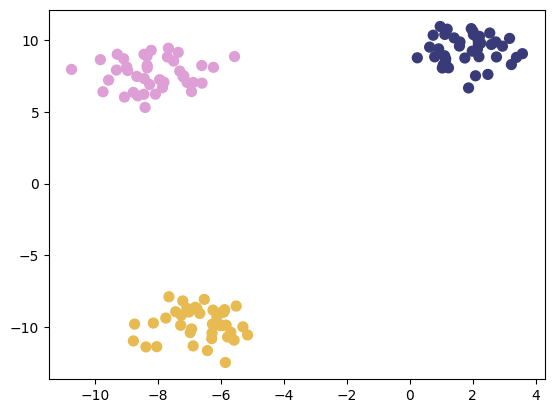

In [4]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=120, n_features=2, centers=3)
plot_2d_clf_problem(X, y)

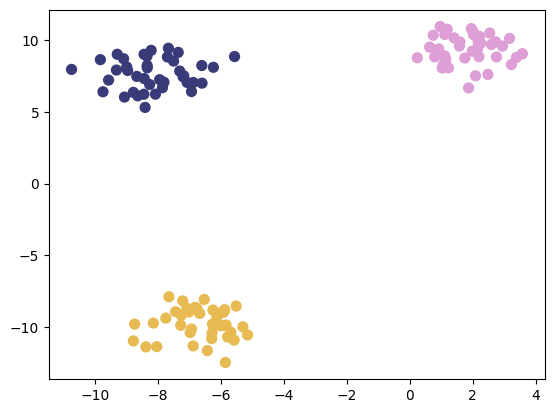

In [5]:
kmeans = KMeans(K=3)
y_pred = kmeans.predict(X)
plot_2d_clf_problem(X, y_pred)